In [82]:
import ugradio
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pf
import lolfunctions
from astropy import units as u
import glob
import doppler
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [83]:
def peak_finder(signal_array, thresh):
    threshold = thresh*(999./1000)
    peaks = []                                                    
    for i in range(2,len(signal_array)-2): 
        if signal_array[i] > signal_array[i+1] and signal_array[i] > signal_array[i-1] and signal_array[i] > signal_array[i-2] and signal_array[i] > signal_array[i+2]:  
            if signal_array[i] > threshold: # or could do ==threshhold and set thresh = .max()                    
                peaks.append(i)
    return peaks

def func(filename):
    lolavgs = np.array([])
    for i in np.arange(len(filename)):
        files_getdata = pf.getdata(filename[i])
        files_headers = pf.getheader(filename[i])
        files_open = pf.open(filename[i])
        
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        avgs = np.zeros(len(files_getdata))
        for j in np.arange(nspec):
            specs = np.sqrt((files_open[j+1].data['auto1_real'])**2 + (files_open[j+1].data['auto0_real'])**2)
            avgs = avgs + specs

        avgs = avgs/nspec
        meanavgs = avgs - np.mean(avgs)
        cutavgs = meanavgs[2500:-3500]
        if i == 0:
            lolavgs = np.append(lolavgs, cutavgs)
        else:
            lolavgs = np.vstack((lolavgs, cutavgs))
            
    return lolavgs


In [84]:
def func_noise(filename):
    lolavgs = np.array([])
    for i in np.arange(len(filename)):
        files_getdata = pf.getdata(filename[i])
        files_headers = pf.getheader(filename[i])
        files_open = pf.open(filename[i])
        
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        avgs = np.zeros(len(files_getdata))
        for j in np.arange(nspec):
            specs = files_open[j+1].data['auto0_real']
            avgs = avgs + specs
            
        avgs = avgs/nspec
        meanavgs = avgs - np.mean(avgs)
        cutavgs = meanavgs[3900:-3900]
        if i == 0:
            lolavgs = np.append(lolavgs, cutavgs)
        else:
            lolavgs = np.vstack((lolavgs, cutavgs))
    return lolavgs

In [85]:
def find_spec_peaks(filename, avgs636, avgs635):
    peaks = np.array([])
    spectras =np.array([])
    for i in np.arange(len(avgs636)):
        i = int(i)
        files_headers = pf.getheader(filename[i])

        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']

        cv635 = lolfunctions.airPLS(avgs635[i], lambda_= 50)[1200:,]
        cv636 = lolfunctions.airPLS(avgs636[i], lambda_= 50)[1200:,]

        flatavgs635 = avgs635[i][1200:,] - cv635
        flatavgs636 = avgs636[i][1200:,] - cv636

        sub = flatavgs635 - flatavgs636


        newsub = np.array([])
        for j in range(len(sub)):
            if j < 400 and sub[j] == max(sub[0:400]):
                newsub = np.append(newsub, 0)
            else:
                newsub = np.append(newsub, sub[j])


        newsub2 = np.array([])   
        for k in range(len(newsub)):
            if k < 400 and newsub[k] == max(newsub[0:400]):
                newsub2 = np.append(newsub2, 0)
            else:
                newsub2 = np.append(newsub2, newsub[k])

        if i == 0:
            spectras = np.append(spectras, newsub2)
        else:
            spectras = np.vstack((spectras, newsub2))

        LO = 635
        freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[2500:-3500]

        fpeaks = peak_finder(newsub2, max(newsub2))

        cents = np.array([])
        for g in fpeaks:
            cents = np.append(cents, lolfunctions.centroid(freqs[1200:,][g-1:g+1],newsub2[g-1:g+1]))

        cents = np.mean(cents)
        #print(i,cents)
        peaks = np.append(peaks,cents)
        
#         plt.figure(figsize=(8,5))
#         plt.plot(freqs[1200:,], newsub2)
#         print 'Peak Frequency =',cents, 'MHz'
#         plt.axvline(cents, c='red')
#         plt.title(i, fontsize=17)
#         plt.xlabel('Frequency [MHZ]', fontsize=17)
#         plt.ylabel('Power', fontsize=17)
#         plt.grid(True)
#         plt.show()
        
    return peaks, spectras

In [86]:
def find_lb_radec_jd(filename):
    gal_l = np.array([])
    gal_b = np.array([])
    RAs = np.array([])
    DECs = np.array([])
    JD = np.array([])
    for i in np.arange(int(len(filename))):
        head = pf.getheader(filename[i])
        glon = head['L']
        glat = head['B']
        gal_l = np.append(gal_l,glon)
        gal_b = np.append(gal_b,glat)
        ra = head['RA']
        dec = head['DEC']
        RAs = np.append(RAs,ra)
        DECs = np.append(DECs,dec)
        jd = head['JD']
        JD = np.append(JD,jd)
    return gal_l, gal_b, RAs, DECs, JD

In [87]:
noiseON = glob.glob('420_data/420_data/LO_*ON*.fits')
noiseOFF = glob.glob('420_data/420_data/LO_*OFF*.fits')

files635 = glob.glob('420_data/420_data/420_data_2/LO_635*.fits')
files636 = glob.glob('420_data/420_data/420_data_2/LO_636*.fits')

files635_2 = glob.glob('420_data_3/LO_635*.fits')
files636_2 = glob.glob('420_data_3/LO_636*.fits')

files635_3 = glob.glob('423_data/LO_635*.fits')
files636_3 = glob.glob('423_data/LO_636*.fits')

In [88]:
# avgON = func_noise(noiseON)
# avgOFF = func_noise(noiseOFF)

# avg635 = func(files635)
# avg636 = func(files636)

# avg635_2 = func(files635_2)
# avg636_2 = func(files636_2)

# avg635_3 = func(files635_3)
# avg636_3 = func(files636_3)

In [89]:
# np.savetxt('avgON', avgON)
# np.savetxt('avgOFF', avgOFF)

In [90]:
avgON = np.loadtxt('avgON') # First Polarization Only
avgOFF = np.loadtxt('avgOFF')# Firsr Polarization Only
avg635 = np.loadtxt('avg635')
avg636 = np.loadtxt('avg636')
avg635_2 = np.loadtxt('avg635_2')
avg636_2 = np.loadtxt('avg636_2')
avg635_3 = np.loadtxt('avg635_3')
avg636_3 = np.loadtxt('avg636_3')

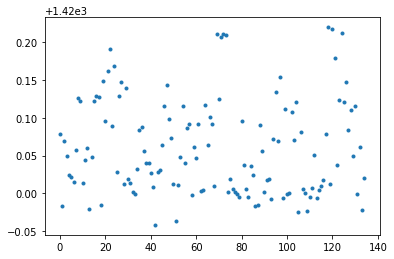

In [91]:
################################## PEAKS FOR NOISE ON ############################
peaksON = np.array([])
spectraON = np.array([])
for i in np.arange(135):
    cvON = lolfunctions.airPLS(avgON[i], lambda_=50)
    subON = avgON[i] - cvON
    
    files_headers = pf.getheader(noiseON[i])
    nspec = files_headers['NSPEC']
    res = files_headers['RES']
    nchan = files_headers['NCHAN']
    
    if i ==0:
        spectraON = np.append(spectraON, subON)
    else:
        spectraON = np.vstack((spectraON, subON))
    
    
    LO = 635
    freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[3900:-3900]

    
    fpeaks = peak_finder(subON, subON[np.argmax(subON)-15])
    cents = np.array([])
    
    for g in fpeaks:
        cents = np.append(cents, lolfunctions.centroid(freqs[g-1:g+1],subON[g-1:g+1]))

    cents = np.mean(cents)
    peaksON = np.append(peaksON,cents)
    
#     print 'Peak Frequency =',cents, 'MHz'
#     plt.figure(figsize=(8,5))
#     plt.plot(freqs, subON)
#     plt.axvline(cents, c='red')
#     plt.title(i, fontsize=17)
#     plt.xlabel('Frequency [MHZ]', fontsize=17)
#     plt.ylabel('Power', fontsize=17)
#     plt.grid(True)
#     plt.show()
plt.plot(peaksON,'.')

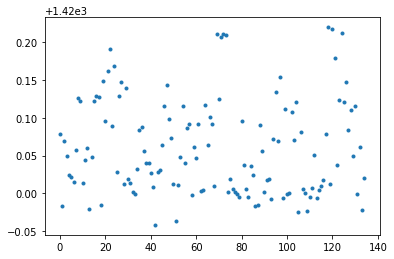

In [92]:
plt.plot(peaksON,'.')

(135L,)


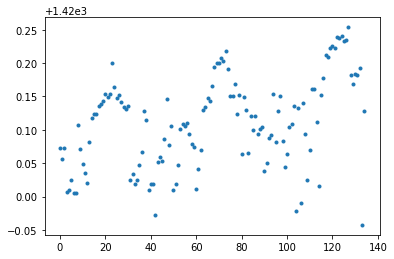

In [93]:
########################## PEAKS FOR NOISE OFF ##################################
spectraOFF = np.array([])
peaksOFF = np.array([])
for i in np.arange(135):
    cvOFF = lolfunctions.airPLS(avgOFF[i], lambda_=500)
    subOFF = avgOFF[i] - cvOFF
    
    files_headers = pf.getheader(noiseOFF[i])
    nspec = files_headers['NSPEC']
    res = files_headers['RES']
    nchan = files_headers['NCHAN']
    
    LO = 635
    freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[3900:-3900]

    if i ==0:
        spectraOFF = np.append(spectraOFF, subOFF)
    else:
        spectraOFF = np.vstack((spectraOFF, subOFF))
    
    
    
    fpeaks = peak_finder(subOFF, subOFF[np.argmax(subOFF)-15])
    
    centsOFF = np.array([])
    for g in fpeaks:
        centsOFF = np.append(centsOFF, lolfunctions.centroid(freqs[g-1:g+1],subOFF[g-1:g+1]))

    centsOFF = np.mean(centsOFF)
    peaksOFF = np.append(peaksOFF,centsOFF)
    
#     print 'Peak Frequency =',cents, 'MHz'
#     plt.figure(figsize=(8,5))
#     plt.plot(freqs, subOFF,'.')
#     plt.axvline(centsOFF, c='red')
#     plt.title(i, fontsize=17)
#     plt.xlabel('Frequency [MHZ]', fontsize=17)
#     plt.ylabel('Power', fontsize=17)
#     plt.grid(True)
#     plt.show()
plt.plot(peaksOFF,'.')
print peaksOFF.shape

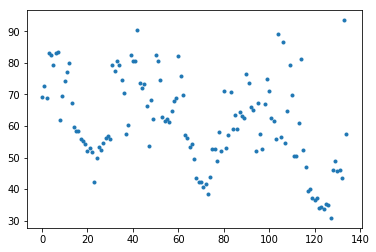

In [94]:
f0 = 1420.4
c = 3e5 #km/s
df = peaksOFF - f0
v = -(df/f0)*c
plt.plot(v,'.')

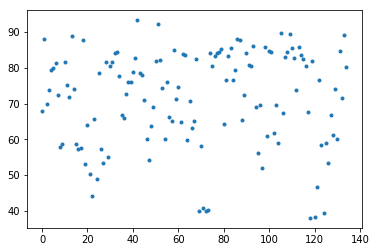

In [95]:
f0 = 1420.4
c = 3e5 #km/s
df = peaksON - f0
v = -(df/f0)*c
plt.plot(v,'.')

In [96]:
print avgON.shape
print avgOFF.shape

print avg635.shape
print avg636.shape

print avg635_2.shape
print avg636_2.shape

print avg635_3.shape
print avg636_3.shape

(135L, 392L)
(135L, 392L)
(580L, 2192L)
(580L, 2192L)
(846L, 2192L)
(846L, 2192L)
(110L, 2192L)
(110L, 2192L)


In [68]:
############################# FINDING ALL THE PEAK FREQUENCIES ####################################
peaks1, spec1 = find_spec_peaks(files635, avg636,avg635)
peaks2, spec2 = find_spec_peaks(files635_2, avg636_2,avg635_2)
peaks3, spec3 = find_spec_peaks(files635_3, avg636_3,avg635_3)

In [116]:
peaks1 = np.loadtxt('peaks1')
peaks2 = np.loadtxt('peaks2')
peaks3 = np.loadtxt('peaks3')
spec1 = np.loadtxt('spec1')
spec2 = np.loadtxt('spec2')
spec3 = np.loadtxt('spec3')

In [98]:
print(spec1.shape)

(580L, 992L)


In [99]:
####################################### FINDING ALL THE LONG, LAT, RA, DEC AND JD ############################
glonOFF,glatOFF, raOFF,decOFF,jdOFF = find_lb_radec_jd(noiseOFF)
glon1 ,glat1, ra1, dec1, jd1 = find_lb_radec_jd(files635)
glon2 ,glat2, ra2, dec2, jd2 = find_lb_radec_jd(files635_2)
glon3 ,glat3, ra3, dec3, jd3 = find_lb_radec_jd(files635_3)


In [100]:
##################### SAVING THE FILES FOR EASIER LOAD #######################################
# np.savetxt('spec1',spec1)
# np.savetxt('peaks1',peaks1)
# np.savetxt('spec2',spec2)
# np.savetxt('peaks2',peaks2)
# np.savetxt('spec3',spec3)
# np.savetxt('peaks3',peaks3)

In [101]:
############## STICHING THE FILES TOGETHER ################
print peaksOFF.shape
print peaks1.shape
total_peaks = np.concatenate((peaksOFF, peaks1, peaks2, peaks3),axis=0)
total_jd = np.concatenate((jdOFF, jd1, jd2, jd3),axis=0)
total_ra = np.concatenate((raOFF, ra1, ra2, ra3),axis=0)
total_dec = np.concatenate((decOFF, dec1, dec2, dec3),axis=0)
total_glon = np.concatenate((glonOFF, glon1, glon2, glon3),axis=0)
total_glat = np.concatenate((glatOFF, glat1, glat2, glat3),axis=0)

(135L,)
(580L,)


In [102]:
v_corrected = np.array([])
for i in range(int(len(total_jd))):
    vel = doppler.get_projected_velocity(total_ra[i],total_dec[i],total_jd[i],obs_lat=37.9183, obs_lon=-122.1067, 
        obs_alt=304, epoch=2451545.)
    v_corrected = np.append(v_corrected, float(vel/1000))
    
f0 = 1420.4
c = 3e5 #km/s
df = total_peaks - f0
v = -(df/f0)*c

In [103]:
corr_v = v - v_corrected

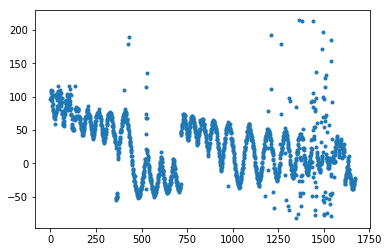

In [104]:
plt.plot(corr_v, '.')

Text(0,0.5,'Galactic Latitude [Degree]')

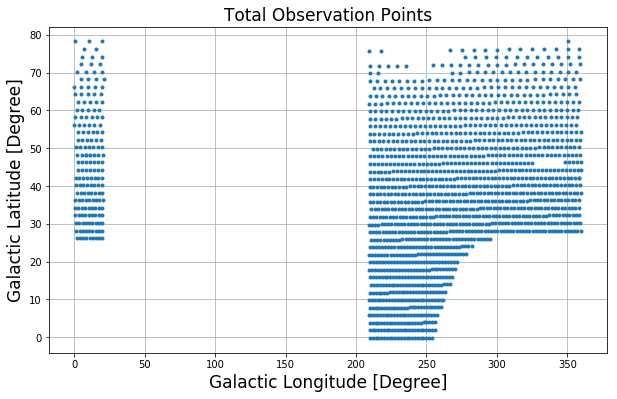

In [105]:
plt.figure(figsize=(10,6))
plt.plot(total_glon,total_glat,'.')
plt.grid(True)
plt.title('Total Observation Points', fontsize=17)
plt.xlabel('Galactic Longitude [Degree]',fontsize=17)
plt.ylabel('Galactic Latitude [Degree]',fontsize=17)

In [315]:
def plot_gal_sphere(l,b,vel,org=0, projection='mollweide'):
    ''' l, b are arrays of the same length.
    l takes values in [0,360), b in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(l+360,360) # shift az values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    tick_labels = np.array([210, 240, 270, 300, 330, 0, 30, 60, 90, 120, 150])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection=projection)
    yee = ax.scatter(np.radians(x),np.radians(b),c=vel,marker=',', vmax=200)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title('North Polar Spur  ',fontsize = 50)
    ax.title.set_fontsize(15)
    ax.set_xlabel("Galactic Longitude [$\degree$]",fontsize = 50)
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Galactic Latitude [$\degree$]",fontsize=50)
    ax.yaxis.label.set_fontsize(12)
    cbar = plt.colorbar(yee)
    cbar.set_label('Correctec Velocities [km/s]',fontsize = 20)
    
   
    ax.grid(True)

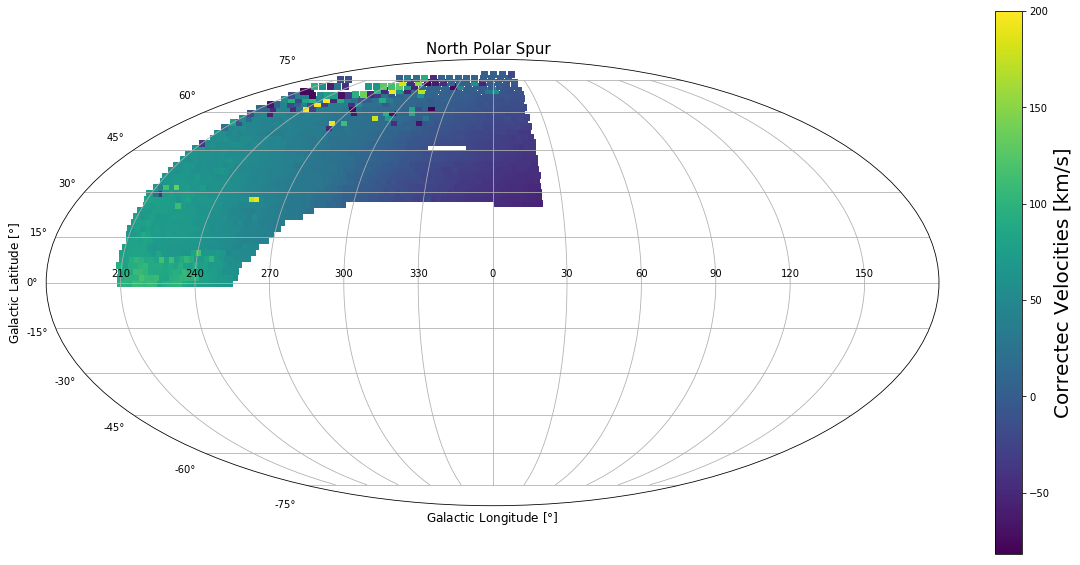

In [316]:
plot_gal_sphere(total_glon,total_glat, corr_v)

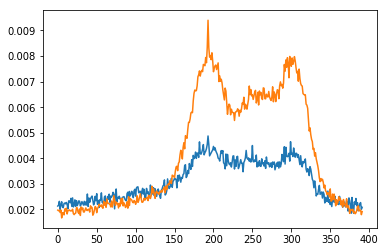

In [108]:
plt.plot(avgON[0])
plt.plot(avgOFF[0])
plt.show()

In [109]:
def func_noise2(filename):
    lolavgs = np.array([])
    for i in np.arange(len(filename)):
        files_getdata = pf.getdata(filename[i])
        files_headers = pf.getheader(filename[i])
        files_open = pf.open(filename[i])
        
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        avgs = np.zeros(len(files_getdata))
        for j in np.arange(nspec):
            specs = files_open[j+1].data['auto0_real']
            avgs = avgs + specs
            
        avgs = avgs/nspec
        #meanavgs = avgs - np.mean(avgs)
        cutavgs = avgs[3900:-3900]
        if i == 0:
            lolavgs = np.append(lolavgs, cutavgs)
        else:
            lolavgs = np.vstack((lolavgs, cutavgs))
    return lolavgs

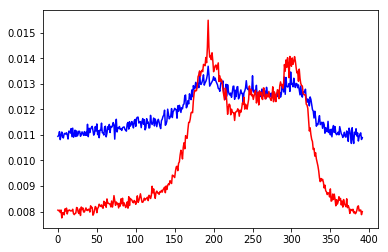

In [110]:
avgON2 = func_noise2(noiseON)
avgOFF2 = func_noise2(noiseOFF)

plt.plot(avgON2[0],'b')
plt.plot(avgOFF2[0],'r')
plt.show()

In [111]:
##### BRIGHTNESS TEMPERATURE ######

t_n = 70 #kelvin of first polarization
tbz = np.zeros(392)
for i in np.arange(135):
    g_tot = (avgON2[i] - avgOFF2[i])/t_n # total gain of each noise spectra
    tb = avgOFF2[i]/g_tot #brightness temperature
    tbz = tbz + tb
avgtb = tbz/135


In [112]:
print avgtb.shape
print freqs.shape

(392L,)
(392L,)


In [113]:
print np.median(avgtb)
print(avgtb.shape)

320.580833175
(392L,)


In [114]:
def loadnpz(path):
    """Loads npz files."""
    a = np.load(path)
    return dict(zip(("data1{}".format(k) for k in a), (a[k] for k in a)))['data1arr_0']

# load in some sample data
y_data = loadnpz('test_spectra.npz')
x_data = loadnpz('test_freqs.npz')

def multiple_peak_finder(signal, threshold = None, width = 1, separation = 1):
    """
    Finds many peaks in a set of data
    
    Parameters
    ----------
    
    signal (numpy array) : The data.
    threshold (float) default = np.mean(sigal):  Data below this value is not considered to be a peak. 
    
    width (int) default = 1: How many data points on each side to compare a possible peak to.
                             Increasing this reduces the number of found peaks.
                             
    separation (int) default = 1: How far apart the peaks must be ( in indices)
                                  Increasing this reduces the number of found peaks.
    
    Returns
    -------
    returns a list of the INDEX locations of the peaks from the signal
    """

    peak_indicies = []

    for i in range(width,len(signal) - width):
        
        left_wing = signal[i - width: i]
        right_wing = signal[i + 1: i + 1 + width]
        
        if threshold == None:
            threshold = np.mean(signal)
        
        if signal[i] > threshold:
            
            if np.all(left_wing < signal[i]) == True:
                if np.all(signal[i] > right_wing) == True:
                    
                    if len(peak_indicies) == 0:
                        peak_indicies.append(i)
                        
                    if len(peak_indicies) > 0 and abs(peak_indicies[-1] - i) >= separation:
                        peak_indicies.append(i)
    return peak_indicies

In [209]:
spec1.shape

(580L, 992L)

In [290]:
def find_dv(spec1, nfiles, filename):
    
    delta_v = np.array([])
    LO = 635

    for i in np.arange(nfiles):
        i = int(i)
        files_headers = pf.getheader(filename[0])
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']

        freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[2500:-3500]
        newfreqs = freqs[1200:,][450:650]
        
        peak_indicies = multiple_peak_finder(spec1[i][450:650],threshold=max(spec1[i][450:650])*6/10, width =1, separation = 1)

        #print(i,'done')
    #     fig = plt.figure(figsize = (15, 7))
    #     plt.plot(newfreqs, spec1[i][450:650], color = 'black', lw = 0.5)
    #     plt.plot(newfreqs[peak_indicies], spec1[i][450:650][peak_indicies], color = 'red', ls = 'none', markersize = 5, marker = 's')
    #     plt.show()
    #     print(df)
    #     for i, peak in enumerate(peak_indicies):
    #         print('Peak %d: (%f, %f)' %(i, newfreqs[peak_indicies][i], spec1[i][500:650][peak_indicies][i]))
        
        c = 3e5
        v1 = -(newfreqs[peak_indicies][0] - 1420.4)*c/1420.4
        v2 = -(newfreqs[peak_indicies][-1] - 1420.4)*c/1420.4
        dv = v2-v1
        df = newfreqs[peak_indicies][-1] - newfreqs[peak_indicies][0]
        delta_v = np.append(delta_v, dv)
    return delta_v



In [307]:
def find_dv_noise(spec1, nfiles, filename):
    
    delta_v = np.array([])
    LO = 635

    for i in np.arange(nfiles):
        i = int(i)
        files_headers = pf.getheader(filename[0])
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']

        freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[3900:-3900]
        newfreqs = freqs
        
        peak_indicies = multiple_peak_finder(spec1[i],threshold=max(spec1[i])*6/10, width =1, separation = 1)

        #print(i,'done')
    #     fig = plt.figure(figsize = (15, 7))
    #     plt.plot(newfreqs, spec1[i][450:650], color = 'black', lw = 0.5)
    #     plt.plot(newfreqs[peak_indicies], spec1[i][450:650][peak_indicies], color = 'red', ls = 'none', markersize = 5, marker = 's')
    #     plt.show()
    #     print(df)
    #     for i, peak in enumerate(peak_indicies):
    #         print('Peak %d: (%f, %f)' %(i, newfreqs[peak_indicies][i], spec1[i][500:650][peak_indicies][i]))
        
        c = 3e5
        v1 = -(newfreqs[peak_indicies][0] - 1420.4)*c/1420.4
        v2 = -(newfreqs[peak_indicies][-1] - 1420.4)*c/1420.4
        dv = v2-v1
        df = newfreqs[peak_indicies][-1] - newfreqs[peak_indicies][0]
        delta_v = np.append(delta_v, dv)
    return delta_v

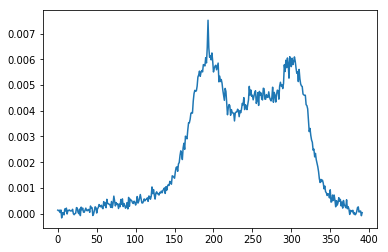

In [306]:
plt.plot(spectraOFF[0])

In [303]:
print spectraOFF.shape
print spec1.shape
print spec2.shape
print spec3.shape

(135L, 392L)
(580L, 992L)
(846L, 992L)
(110L, 992L)


In [308]:
dvOFF = find_dv_noise(spectraOFF,135, noiseOFF)
dv1 = find_dv(spec1,580,files635)
dv2 = find_dv(spec2,846,files635)
dv3 = find_dv(spec3,110,files635)

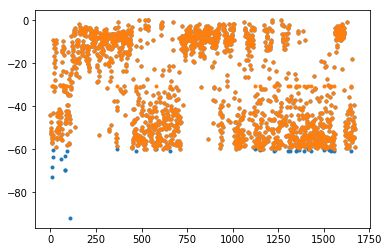

In [321]:
total_dv = np.concatenate((dvOFF,dv1,dv2,dv3), axis=0)
plt.plot(total_dv,'.')

new_totaldv= np.array([])
for i in np.arange(len(total_dv)):
    if total_dv[i] < -60:
        new_totaldv = np.append(new_totaldv, np.mean(total_dv))
    else:
        new_totaldv = np.append(new_totaldv, total_dv[i])
        
plt.plot(new_totaldv,'.')

In [338]:
N_HI.shape
corr_dv = new_totaldv - v_corrected
N_HI = 1.8e18*320*corr_dv

In [345]:
def plot_gal_sphere2(l,b,vel,org=0, projection='mollweide'):
    ''' l, b are arrays of the same length.
    l takes values in [0,360), b in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(l+360,360) # shift az values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    tick_labels = np.array([210, 240, 270, 300, 330, 0, 30, 60, 90, 120, 150])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection=projection)
    yee = ax.scatter(np.radians(x),np.radians(b),c=vel,marker=',',vmin=0)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title('North Polar Spur  ',fontsize = 50)
    ax.title.set_fontsize(15)
    ax.set_xlabel("Galactic Longitude [$\degree$]",fontsize = 50)
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Galactic Latitude [$\degree$]",fontsize=50)
    ax.yaxis.label.set_fontsize(12)
    cbar = plt.colorbar(yee)
    cbar.set_label('HI Coloumn Density [$cm^-2$]',fontsize = 20)
    
   
    ax.grid(True)

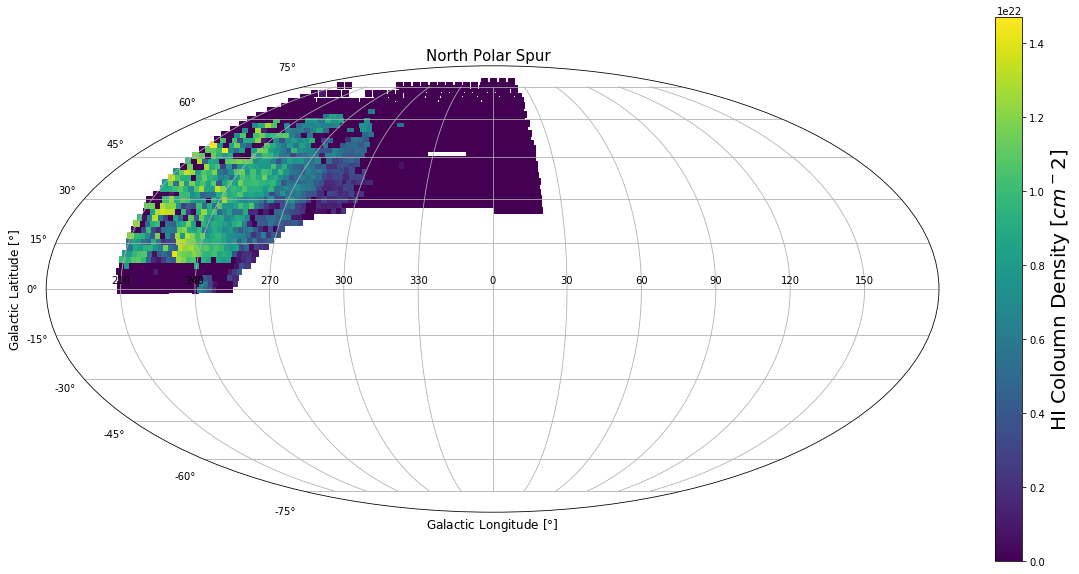

In [346]:
plot_gal_sphere2(total_glon,total_glat, N_HI)